<a href="https://colab.research.google.com/github/wisnuwicaksono10/UAS_BDPAL/blob/main/UAS_BDPAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# **Initialize Spark Session**

In [ ]:
spark = SparkSession.builder.appName("DiabetesPrediction").getOrCreate()


# **Load Dataset**

In [ ]:
data_path = "pima_diabetes.csv"  # Replace with the actual path
data = spark.read.csv("/content/diabetes.csv", header=True, inferSchema=True)
data.show(5)


+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



# **Dataset Description**

In [ ]:
print("Dataset Columns:", data.columns)
print("Target Column: 'Outcome' (1 = Diabetes, 0 = Non-Diabetes)")
column_descriptions = {
    "Pregnancies": "Number of times pregnant",
    "Glucose": "Plasma glucose concentration after 2 hours in an oral glucose tolerance test",
    "BloodPressure": "Diastolic blood pressure (mm Hg)",
    "SkinThickness": "Triceps skin fold thickness (mm)",
    "Insulin": "2-Hour serum insulin (mu U/ml)",
    "BMI": "Body mass index (weight in kg/(height in m)^2)",
    "DiabetesPedigreeFunction": "Diabetes pedigree function",
    "Age": "Age (years)",
    "Outcome": "Class variable (0 or 1, where 1 means diabetes)"
}
for col, desc in column_descriptions.items():
    print(f"{col}: {desc}")


Dataset Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
Target Column: 'Outcome' (1 = Diabetes, 0 = Non-Diabetes)
Pregnancies: Number of times pregnant
Glucose: Plasma glucose concentration after 2 hours in an oral glucose tolerance test
BloodPressure: Diastolic blood pressure (mm Hg)
SkinThickness: Triceps skin fold thickness (mm)
Insulin: 2-Hour serum insulin (mu U/ml)
BMI: Body mass index (weight in kg/(height in m)^2)
DiabetesPedigreeFunction: Diabetes pedigree function
Age: Age (years)
Outcome: Class variable (0 or 1, where 1 means diabetes)


# **Pre-processing**

In [ ]:
data = data.withColumnRenamed("Outcome", "Diabetes")
data = data.na.fill(0)  # Fill missing values with 0
data.printSchema()
data.describe().show()


root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = false)
 |-- DiabetesPedigreeFunction: double (nullable = false)
 |-- Age: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|          Diabetes|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|    

# **Exploratory Data Analysis (EDA)**

**Distribusi Variabel Targett**

<ipython-input-10-e1f546402cfa>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Diabetes", y="count", data=outcome_counts, palette="viridis")


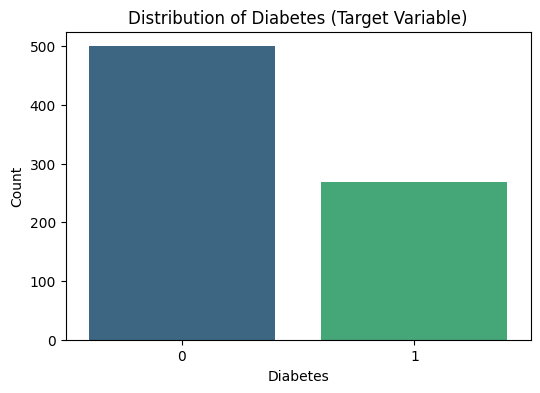

In [ ]:
outcome_counts = data.groupBy("Diabetes").count().toPandas()
plt.figure(figsize=(6, 4))
sns.barplot(x="Diabetes", y="count", data=outcome_counts, palette="viridis")
plt.title("Distribution of Diabetes (Target Variable)")
plt.xlabel("Diabetes")
plt.ylabel("Count")
plt.show()


**Distribusi Level Glukosa**

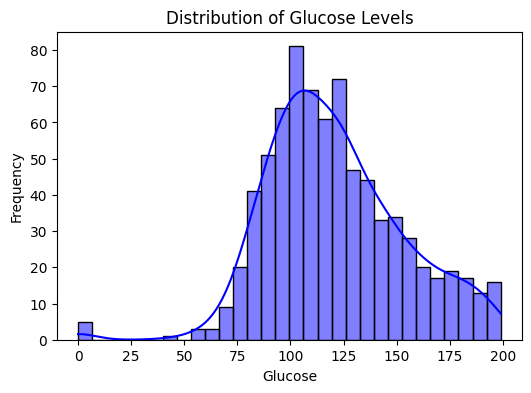

In [ ]:
glucose_data = data.select("Glucose").toPandas()
plt.figure(figsize=(6, 4))
sns.histplot(glucose_data["Glucose"], bins=30, kde=True, color="blue")
plt.title("Distribution of Glucose Levels")
plt.xlabel("Glucose")
plt.ylabel("Frequency")
plt.show()


**Distribusi Kelompok Umur**

<ipython-input-13-dc98618de167>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="AgeGroup", y="count", data=age_counts, palette="coolwarm")


Text(0.5, 1.0, 'Distribution of Age Groups')

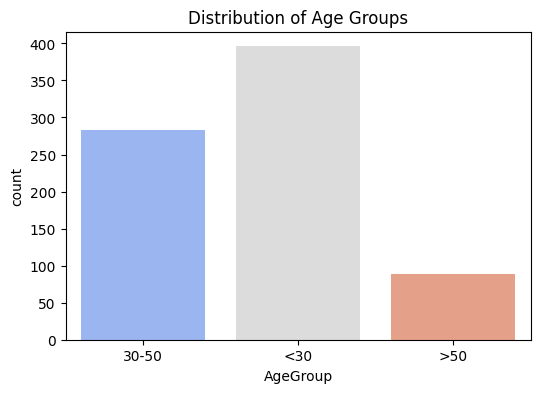

In [ ]:
from pyspark.sql.functions import col, when

# EDA: Distribusi Kelompok Usia
age_data = data.withColumn("AgeGroup", when(col("Age") < 30, "<30")
                          .when(col("Age") < 50, "30-50")
                          .otherwise(">50"))
age_counts = age_data.groupBy("AgeGroup").count().toPandas()

# Visualisasi
plt.figure(figsize=(6, 4))
sns.barplot(x="AgeGroup", y="count", data=age_counts, palette="coolwarm")
plt.title("Distribution of Age Groups")


**Proporsi Diabetes**

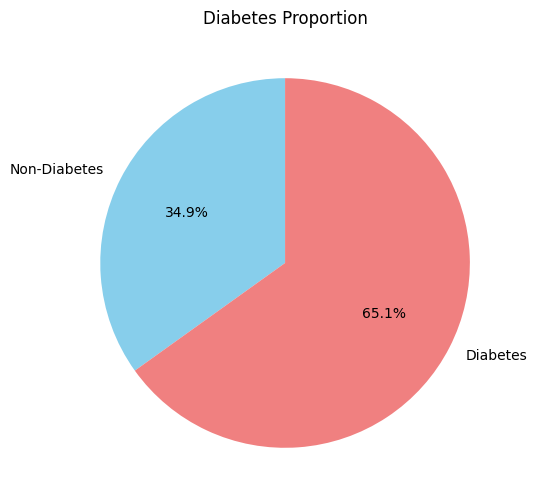

In [ ]:
diabetes_proportion = outcome_counts.set_index("Diabetes")
plt.figure(figsize=(6, 6))
diabetes_proportion["count"].plot.pie(autopct="%1.1f%%", startangle=90, colors=["skyblue", "lightcoral"], labels=["Non-Diabetes", "Diabetes"])
plt.title("Diabetes Proportion")
plt.ylabel("")
plt.show()


**Korelasi Antar Fitur**

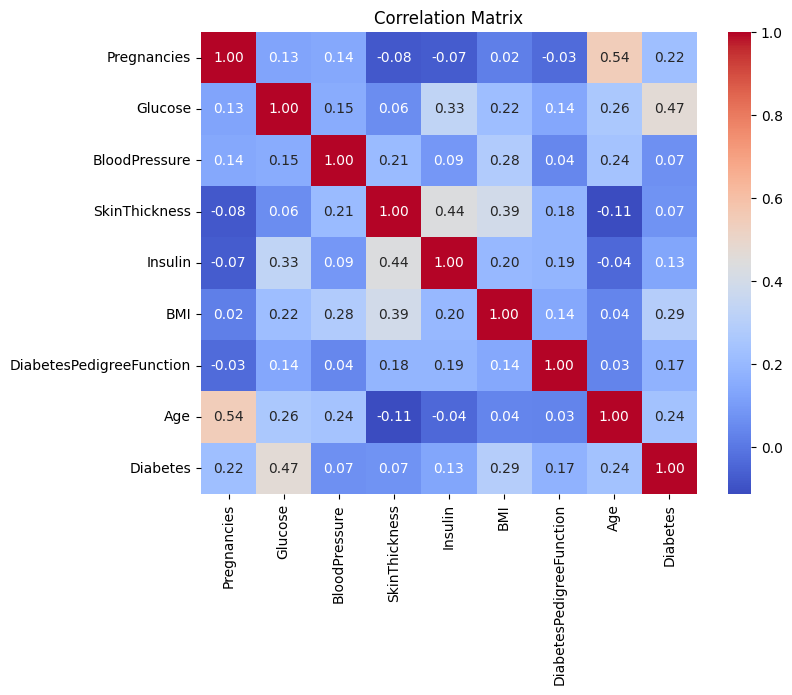

In [ ]:
numeric_columns = [col for col, dtype in data.dtypes if dtype in ('int', 'double')]
corr_data = data.select(numeric_columns).toPandas().corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_data, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


# **Feature Selection**

In [ ]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data).select("features", "Outcome")


# **Split Data**

In [ ]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


# **Model Initialization**

In [ ]:
rf = RandomForestClassifier(labelCol="Outcome", featuresCol="features", seed=42)
gbt = GBTClassifier(labelCol="Outcome", featuresCol="features", seed=42)
lr = LogisticRegression(labelCol="Outcome", featuresCol="features")


# **Train and Evaluate Models**

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def evaluate_model(model, train_data, test_data):
    # Melatih model
    trained_model = model.fit(train_data)

    # Prediksi pada data uji
    predictions = trained_model.transform(test_data)

    # Evaluator untuk AUC
    evaluator = BinaryClassificationEvaluator(labelCol="Outcome", metricName="areaUnderROC")
    auc = evaluator.evaluate(predictions)

    # Evaluasi menggunakan MulticlassClassificationEvaluator untuk Accuracy, F1, Precision, Recall
    accuracy_eval = MulticlassClassificationEvaluator(labelCol="Outcome", metricName="accuracy")
    f1_eval = MulticlassClassificationEvaluator(labelCol="Outcome", metricName="f1")
    precision_eval = MulticlassClassificationEvaluator(labelCol="Outcome", metricName="weightedPrecision")
    recall_eval = MulticlassClassificationEvaluator(labelCol="Outcome", metricName="weightedRecall")

    # Mengumpulkan hasil evaluasi
    metrics = {
        "AUC": auc,
        "Accuracy": accuracy_eval.evaluate(predictions),
        "F1 Score": f1_eval.evaluate(predictions),
        "Precision": precision_eval.evaluate(predictions),
        "Recall": recall_eval.evaluate(predictions)
    }

    # Menampilkan hasil
    print(f"{model.__class__.__name__} Metrics: {metrics}")

    return trained_model, metrics

# Evaluasi untuk model Random Forest, Gradient Boosted Trees, dan Logistic Regression
rf_model, rf_metrics = evaluate_model(rf, train_data, test_data)
gbt_model, gbt_metrics = evaluate_model(gbt, train_data, test_data)
lr_model, lr_metrics = evaluate_model(lr, train_data, test_data)


RandomForestClassifier Metrics: {'AUC': 0.8498546511627906, 'Accuracy': 0.7723577235772358, 'F1 Score': 0.7661038148843028, 'Precision': 0.7670784500052792, 'Recall': 0.7723577235772358}
GBTClassifier Metrics: {'AUC': 0.7616279069767443, 'Accuracy': 0.7154471544715447, 'F1 Score': 0.7146570186929492, 'Precision': 0.7139630920118725, 'Recall': 0.7154471544715447}
LogisticRegression Metrics: {'AUC': 0.8595930232558139, 'Accuracy': 0.7967479674796748, 'F1 Score': 0.7920029037325165, 'Precision': 0.7929866367629194, 'Recall': 0.7967479674796748}


# **Hyperparameter Tuning**

In [ ]:
train_data.printSchema()


root
 |-- features: vector (nullable = true)
 |-- Outcome: integer (nullable = true)



In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="Outcome", metricName="areaUnderROC")


In [ ]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [ ]:
from pyspark.ml.feature import VectorAssembler

# Cek terlebih dahulu nama kolom dalam dataset dengan printSchema()
train_data.printSchema()

# Misalnya kolom-kolom yang benar adalah: 'Pregnancy', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age'
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Initialize the VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Perform the transformation only once
train_data_assembled = train_data # Assign train_data to train_data_assembled without any transformation
train_data_assembled.show(5)

root
 |-- features: vector (nullable = true)
 |-- Outcome: integer (nullable = true)

+--------------------+-------+
|            features|Outcome|
+--------------------+-------+
|[0.0,57.0,60.0,21...|      0|
|[0.0,67.0,76.0,45...|      0|
|[0.0,74.0,52.0,27...|      0|
|[0.0,78.0,88.0,36...|      0|
|[0.0,84.0,64.0,35...|      0|
+--------------------+-------+
only showing top 5 rows



In [ ]:
def tune_model(model, train_data):
    # Menyesuaikan grid parameter sesuai model
    if isinstance(model, LogisticRegression):
        param_grid = ParamGridBuilder() \
            .addGrid(model.regParam, [0.01, 0.1]) \
            .addGrid(model.elasticNetParam, [0.0, 0.5]) \
            .build()
    else:
        param_grid = ParamGridBuilder() \
            .addGrid(model.numTrees, [50, 100]) \
            .addGrid(model.maxDepth, [5, 10]) \
            .build()

    # CrossValidator untuk pemilihan parameter terbaik
    crossval = CrossValidator(estimator=model,
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,  # Evaluator untuk mengukur kinerja model
                               numFolds=3)  # Bisa disesuaikan dengan jumlah fold yang diinginkan

    # Melatih model menggunakan CrossValidator
    cv_model = crossval.fit(train_data)
    return cv_model

In [ ]:
# Pilih model terbaik dari best_models
best_models = [lr,rf, gbt]


# Tuning model
tuned_model_1 = tune_model(best_models[0], train_data)  # Tuning model pertama
tuned_model_2 = tune_model(best_models[1], train_data)  # Tuning model kedua

# Evaluasi AUC dari model yang sudah di-tune
tuned_auc_1 = evaluator.evaluate(tuned_model_1.bestModel.transform(test_data))
tuned_auc_2 = evaluator.evaluate(tuned_model_2.bestModel.transform(test_data))

# Bandingkan AUC
if tuned_auc_1 > tuned_auc_2:
    final_model = tuned_model_1
else:
    final_model = tuned_model_2

# Menampilkan model yang terpilih dan nilai AUC-nya
print(f"Final model: {final_model.bestModel}")
print(f"AUC for final model: {max(tuned_auc_1, tuned_auc_2)}")

Final model: LogisticRegressionModel: uid=LogisticRegression_4020afabf4d8, numClasses=2, numFeatures=6
AUC for final model: 0.858139534883721


In [1]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [2]:
!git config --global user.email "wisnuwicaksana100@students.amikom.ac.id"
!git config --global user.name "wisnuwicaksono10"

In [3]:
!git add .

In [4]:
!git status

On branch master

No commits yet

Changes to be committed:
  (use "git rm --cached <file>..." to unstage)
	new file:   .config/.last_opt_in_prompt.yaml
	new file:   .config/.last_survey_prompt.yaml
	new file:   .config/.last_update_check.json
	new file:   .config/active_config
	new file:   .config/config_sentinel
	new file:   .config/configurations/config_default
	new file:   .config/default_configs.db
	new file:   .config/gce
	new file:   .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
	new file:   .config/logs/2025.01.16/14.28.29.838121.log
	new file:   .config/logs/2025.01.16/14.28.49.862607.log
	new file:   .config/logs/2025.01.16/14.28.58.277099.log
	new file:   .config/logs/2025.01.16/14.28.59.271536.log
	new file:   .config/logs/2025.01.16/14.29.07.896294.log
	new file:   .config/logs/2025.01.16/14.29.08.514080.log
	new file:   sample_data/README.md
	new file:   sample_data/anscombe.json
	new file:   sample_data/california_housing_test.csv
	new file:   sam

In [5]:
!git commit -m "redy"

[master (root-commit) 93d74d7] redy
 21 files changed, 51023 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/default_configs.db
 create mode 100644 .config/gce
 create mode 100644 .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 create mode 100644 .config/logs/2025.01.16/14.28.29.838121.log
 create mode 100644 .config/logs/2025.01.16/14.28.49.862607.log
 create mode 100644 .config/logs/2025.01.16/14.28.58.277099.log
 create mode 100644 .config/logs/2025.01.16/14.28.59.271536.log
 create mode 100644 .config/logs/2025.01.16/14.29.07.896294.log
 create mode 100644 .config/logs/2025.01.16/14.29.08.514080.log
 create mode 100755 sample_data/README.md
 create mode 100755 sample_

In [6]:
!git branch -M main

In [7]:
!git remote add origin https://github.com/wisnuwicaksono10/UAS_BDPAL.git

Enumerating objects: 28, done.
Counting objects: 100% (28/28), done.
Delta compression using up to 2 threads
Compressing objects: 100% (21/21), done.
Writing objects: 100% (28/28), 8.42 MiB | 2.33 MiB/s, done.
Total 28 (delta 5), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (5/5), done.
To https://github.com/wisnuwicaksono10/UAS_BDPAL.git
 * [new branch]      main -> main
